# **LSTM Model**

In [ ]:
#downloading load2vec model

!python -m spacy download en_core_web_md


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
# importing spacy library and loading word2vec model

import en_core_web_md
nlp = en_core_web_md.load()
print ("Loaded WordVec")

# mounting the drive to access image features

from google.colab import drive
drive.mount('/content/drive')
# %cd drive/My\ Drive/vqa       
# !ls

Loaded WordVec
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys, warnings
warnings.filterwarnings("ignore")
from random import shuffle, sample
import pickle as pk
import gc
import operator
from collections import defaultdict
from itertools import zip_longest
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import LabelEncoder
import spacy
from keras.optimizers import Adam

In [ ]:
def most_frequent_ans(training_questions, answer_train, images_train, upper_lim):
    # Based on the treshold limit, this function returns tuple of lists of filtered questions, answers and imageIDs.
    # It filters out the samples based on the frequency of occurance of the answer.
    # Parameters:
    # training_questions = training questions, answers_train = corresponding training answers,
    # images_train = corresponding training imageIDs, upper_lim = number of answers/classes

    freq_ans = defaultdict(int)
    for ans in answer_train:
        freq_ans[ans] += 1

    sort_freq = sorted(freq_ans.items(), key=operator.itemgetter(1), reverse=True)[0:upper_lim]
    top_ans, top_freq = zip(*sort_freq)
    new_answers_train = list()
    new_questions_train = list()
    new_images_train = list()
    for ans, ques, img in zip(answer_train, training_questions, images_train):
        if ans in top_ans:
            new_answers_train.append(ans)
            new_questions_train.append(ques)
            new_images_train.append(img)

    return (new_questions_train, new_answers_train, new_images_train)

def grouped(iterable, n, fillvalue=None):
    # Groups the samples accorading to batch size and returns a zip object
    # Parameters:
    # iterable = samples to group, n = batch size, fillvalue = to fill empty values with
    
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def fetch_sum_of_answers(answers, encoder):
    # Converts a class vector (integers) to binary class matrix and returns tensorflow object
    # Parameters:
    # answers = answers in string literals, encoder = a scikit-learn LabelEncoder object
    
    assert not isinstance(answers, str)
    y = encoder.transform(answers)
    nb_classes = encoder.classes_.shape[0]
    Y = tf.keras.utils.to_categorical(y, nb_classes)
    return Y

In [ ]:
# Loading the training image feature pickle file
import pickle as pk
pkl_file = open('/content/drive/MyDrive/VQA/image_features.pkl', 'rb')
features= pk.load(pkl_file)

In [ ]:
# Loading the testing image features pickle file
pkl_file_val = open('/content/drive/MyDrive/VQA/image_features_val.pkl', 'rb')
features_val = pk.load(pkl_file_val)

In [ ]:
def fetch_image_matrix_trian(img_list):
  # Gets the 4096-dimensional CNN features for the given imageID and returns a numpy array of size (nb_samples, nb_dimensions)
  # Parameters:
  # img_list = list of imageIDs

	image_matrix = np.zeros((len(img_list), 4096))
	index = 0
	for id in img_list:
		image_matrix[index] = features['%012d' %(int(id))]
		index = index + 1
	return image_matrix

def fetch_image_matrix_val(img_list):
	
	# Gets the 4096-dimensional CNN features for the given imageID and returns a numpy array of size (nb_samples, nb_dimensions)
	# Parameters:
	# img_list = list of imageIDs

	image_matrix = np.zeros((len(img_list), 4096))
	index = 0
	for id in img_list:
		image_matrix[index] = features_val['%012d' %(int(id))]
		index = index + 1
	return image_matrix

def get_answers_matrix(answers, encoder):
	# Converts string objects to class labels and returns numpy array of shape (nb_samples, nb_classes)
	# Parameters:
  # answers = asnwers in string format
  # encoder = a scikit-learn LabelEncoder object

	assert not isinstance(answers, str)
	y = encoder.transform(answers) #string to numerical class
	nb_classes = encoder.classes_.shape[0]
	Y = np_utils.to_categorical(y, nb_classes)
	return Y

def get_questions_tensor_timeseries(questions, nlp, timesteps):
	# Returns a time series of word vectors for tokens in the question as a numpy ndarray of shape: (nb_samples, timesteps, word_vec_dim)
	# Parameters:
	# questions = questions, nlp = word2vec model, timesteps = uniform length of question
	
	assert not isinstance(questions, str)
	nb_samples = len(questions)
	word_vec_dim = nlp(questions[0])[0].vector.shape[0]
	questions_tensor = np.zeros((nb_samples, timesteps, word_vec_dim))
	for i in range(len(questions)):
		tokens = nlp(questions[i])
		for j in range(len(tokens)):
			if j<timesteps:
				questions_tensor[i,j,:] = tokens[j].vector
	return questions_tensor

In [ ]:
#Loading dataset and necessary files

training_questions     = open("/content/drive/MyDrive/VQA/ques_train.txt","rb").read().decode('utf8').splitlines()
training_questions_len = open("/content/drive/MyDrive/VQA/ques_train_len.txt","rb").read().decode('utf8').splitlines()
answers_train          = open("/content/drive/MyDrive/VQA/answer_train.txt","rb").read().decode('utf8').splitlines()
images_train           = open("/content/drive/MyDrive/VQA/images_id.txt","rb").read().decode('utf8').splitlines()
img_ids                = open('/content/drive/MyDrive/VQA/vgg_IDMap.txt').read().splitlines()

sample(list(zip(images_train, training_questions, answers_train)), 5)

[('163331', 'What sport is the athlete playing?', 'tennis'),
 ('94807', 'How is the pattern on his shirt?', 'plaid'),
 ('416776', 'What is on top of the pasta?', 'cheese'),
 ('4891',
  'What is the purpose of the vehicle nearest the jet the photo was taken from?',
  'baggage'),
 ('389793', 'What kind of flowers are those?', 'lilies')]

In [ ]:
# Garbage collection
gc.collect()

50

In [ ]:
# Filtering the training dataset based on the number of classes and its frequency of occurance

upper_lim = 1000 
print (len(training_questions), len(answers_train),len(images_train))
training_questions, answers_train, images_train = most_frequent_ans(training_questions, answers_train, images_train, upper_lim)
training_questions_len, training_questions, answers_train, images_train = (list(t) for t in zip(*sorted(zip(training_questions_len, 
                                                                                                          training_questions, answers_train, 
                                                                                                          images_train))))
print (len(training_questions), len(answers_train),len(images_train))

# Getting unique answers and storing them in .sav file

lbl = LabelEncoder()
lbl.fit(answers_train)
nb_classes = len(list(lbl.classes_))
print(nb_classes)
pk.dump(lbl, open('/content/drive/MyDrive/VQA/label_encoder_lstm.sav','wb'))


# Hyperparameter tuning and model configurations

batch_size               =      128
img_dim                  =     4096
word2vec_dim             =      300
num_hidden_nodes_mlp     =     1024
num_hidden_nodes_lstm    =      512
num_layers_mlp           =        3
num_layers_lstm          =        3
dropout                  =       0.3
activation_mlp           =     'tanh'
num_epochs               =      4

# Building the image model

image_model = tf.keras.Sequential([tf.keras.layers.Reshape(input_shape = (img_dim,), target_shape=(img_dim,), name='Feeding_image_vectors_size_4096')], name='Image_Model')
image_model.add(tf.keras.layers.Dense(num_hidden_nodes_mlp, kernel_initializer='uniform', name = 'Image_MLP_Hidden_layer_size_1024'))
image_model.add(tf.keras.layers.Activation('tanh', name='Image_MLP_Activation_tanh'))
image_model.add(tf.keras.layers.Dropout(0.5, name='Image_MLP_Dropout_0.5'))
image_model.summary()

# Building the question model

language_model = tf.keras.Sequential([tf.keras.layers.LSTM(num_hidden_nodes_lstm,return_sequences=True, input_shape=(None, word2vec_dim), name='Feeding_question_vectors_to_LSTM_Layer_1'),
                                      tf.keras.layers.LSTM(num_hidden_nodes_lstm, return_sequences=True, name='LSTM_layer_2')
                                      ,tf.keras.layers.LSTM(num_hidden_nodes_lstm, return_sequences=False, name='LSTM_layer_3')
                                      ], name = 'Language_Model')
language_model.add(tf.keras.layers.Dense(num_hidden_nodes_mlp, kernel_initializer='uniform', name = 'Question_MLP_Hidden_layer_size_1024'))
language_model.add(tf.keras.layers.Activation('tanh', name='Question_MLP_Activation_tanh'))
language_model.add(tf.keras.layers.Dropout(0.5, name='Question_MLP_Dropout_0.5'))

language_model.summary()

# Concatenating image model and question model to build the final model

upper_lim = 1000 #  

merged=tf.keras.layers.concatenate([language_model.output,image_model.output], axis =-1, name='Merging_language_model_and_image_model')

model =tf.keras.Sequential(name='CNN_LSTM_Model')(merged)
model = tf.keras.layers.Dense(num_hidden_nodes_mlp, kernel_initializer='uniform', name = 'Combined_MLP_Hidden_layer_size_1024')(model)
model = tf.keras.layers.Activation('tanh', name='Combined_MLP_Activation_tanh')(model)
model = tf.keras.layers.Dropout(0.5, name='Combined_MLP_Dropout_0.5')(model)
model = tf.keras.layers.Dense(upper_lim, name='Fully_Connected_Output_layer_size_1000')(model)
out =   tf.keras.layers.Activation("softmax", name='Softmax_Output_Probablities')(model)
model = tf.keras.Model([language_model.input, image_model.input], out, name='LSTM_CNN_Model')

# Compiling the model

model.load_weights('/content/drive/MyDrive/VQA/Weights_Adam/LSTM_1000classes_epoch_16.hdf5')
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001),metrics=['acc'])
#tf.keras.utils.plot_model(model, to_file='CNN_LSTM_model_v2.png')

248349 248349 248349
215407 215407 215407
1000
Model: "Image_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feeding_image_vectors_size_4 (None, 4096)              0         
_________________________________________________________________
Image_MLP_Hidden_layer_size_ (None, 1024)              4195328   
_________________________________________________________________
Image_MLP_Activation_tanh (A (None, 1024)              0         
_________________________________________________________________
Image_MLP_Dropout_0.5 (Dropo (None, 1024)              0         
Total params: 4,195,328
Trainable params: 4,195,328
Non-trainable params: 0
_________________________________________________________________
Model: "Language_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Feeding_question_vectors_to_ (None, None

# **----------Training starts here----------**

In [ ]:
loss_epoch = []
accuracy_epoch = []

for k in range(num_epochs):
    loss_per_epoch = 0
    acc_per_epoch=0
    progbar = tf.keras.utils.Progbar(len(training_questions))

    index_shuffle = list(range(len(training_questions)))
    shuffle(index_shuffle)
    training_questions = [training_questions[i] for i in index_shuffle]
    answers_train = [answers_train[i] for i in index_shuffle]
    images_train = [images_train[i] for i in index_shuffle]

    for ques_batch, ans_batch, im_batch in zip(grouped(training_questions, batch_size, 
                                                       fillvalue=training_questions[-1]), 
                                               grouped(answers_train, batch_size, 
                                                       fillvalue=answers_train[-1]), 
                                               grouped(images_train, batch_size, fillvalue=images_train[-1])):
        timestep = len(nlp(ques_batch[-1]))
        X_ques_batch = get_questions_tensor_timeseries(ques_batch, nlp, timestep)
        X_ques_batch = np.array(X_ques_batch)
        X_img_batch = fetch_image_matrix_trian(im_batch)
        X_img_batch = np.array(X_img_batch) 
        Y_batch = fetch_sum_of_answers(ans_batch, lbl)
        Y_batch = np.array(Y_batch)
        loss = model.train_on_batch([X_ques_batch, X_img_batch], Y_batch)
   
        loss_per_epoch = loss_per_epoch + loss[0]
        acc_per_epoch=acc_per_epoch + loss[1]
     
        progbar.add(batch_size, values=[('train loss', loss[0]), ('train acc',loss[1]),('epoch', k)]) 
        
    if k%1 == 0:
        model.save_weights("LSTM_1000classes" + "_epoch_{:02d}.hdf5".format(k))

    loss_epoch.append(loss_per_epoch)
    np.save('loss.npy', np.array(loss_epoch))
    accuracy_epoch.append(acc_per_epoch)
    np.save('accuracy.npy', np.array(accuracy_epoch))

model.save_weights("LSTM_1000classes" + "_epoch_{:02d}.hdf5".format(k))

215424/215407 [==============================] - 3712s 17ms/step - train loss: 2.1329 - train acc: 0.4954 - epoch: 4.0000


In [ ]:
# Loading the weights and compiling the model to test

model.load_weights('LSTM_1000classes_epoch_03.hdf5') 
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001),metrics=['acc'])

print ("Model Loaded with Weights")

# Loading the testing dataset and related files

val_imgs = open('/content/drive/MyDrive/VQA/val_images_id.txt','rb').read().decode('utf-8').splitlines()
val_ques = open('/content/drive/MyDrive/VQA/ques_val.txt','rb').read().decode('utf-8').splitlines()
val_ans  = open('/content/drive/MyDrive/VQA/answer_val.txt','rb').read().decode('utf-8').splitlines()
print (len(val_ques), len(val_imgs),len(val_ans))

# Filtering the testing dataset based on the number of answers and its frequency of occurance

upper_lim = 1000 
val_ques, val_ans, val_imgs = most_frequent_ans(val_ques, val_ans, val_imgs, upper_lim)
print (len(val_ques), len(val_imgs),len(val_ans))

# Loading the label encoder for classes

label_encoder = pk.load(open('/content/drive/MyDrive/VQA/label_encoder_lstm.sav','rb'))


Model Loaded with Weights
121512 121512 121512
105175 105175 105175


# **----------Testing starts here----------**

105216/105175 [==============================] - 1361s 13ms/step
Final Accuracy is 0.47860232945091513
Yes or no Accuracy is 0.6708783147568266
Number Accuracy is 0.2917737789203085
Other Accuracy is 0.505475861618941


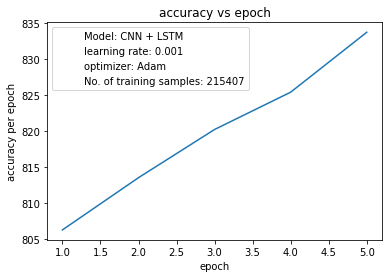

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred = []
batch_size = 128 
progbar = tf.keras.utils.Progbar(len(val_ques))
for qu_batch,an_batch,im_batch in zip(grouped(val_ques, batch_size, 
                                                   fillvalue=val_ques[0]), 
                                           grouped(val_ans, batch_size, 
                                                   fillvalue=val_ans[0]), 
                                           grouped(val_imgs, batch_size, 
                                                   fillvalue=val_imgs[0])):
    timesteps = len(nlp(qu_batch[-1]))
    X_ques_batch = get_questions_tensor_timeseries(qu_batch, nlp, timesteps)

    X_i_batch = fetch_image_matrix_val(im_batch)
    
    X_batch = [X_ques_batch, X_i_batch]
    y_predict = model.predict(X_batch, verbose=0)
    y_predict = np.argmax(y_predict,axis=1)
    y_pred.extend(label_encoder.inverse_transform(y_predict))
    progbar.add(batch_size)

# Calculating the accuracy and saving the results in a text file

correct_val = 0.0
total = 0 

correct_total = 0.0
total = 0.0

correct_yes_or_no = 0.0
total_yes_or_no = 0.0

correct_number = 0.0
total_number = 0.0

correct_other = 0.0
total_other = 0.0

f1 = open('res_v2_lstm_cnn_1000classes_70epoch.txt','w') 

for pred, truth, ques, img in zip(y_pred, val_ans, val_ques, val_imgs):
    t_count = 0
    for _truth in truth.split(';'):
        if pred == truth:
            t_count += 1 
    if t_count >=1:
        correct_val +=1
    else:
        correct_val += float(t_count)/3

    total +=1

    if truth == 'yes' or truth == 'no':
      if pred == truth:
        correct_yes_or_no += 1
      total_yes_or_no += 1
    
    if truth.isnumeric():
      if pred == truth:
        correct_number += 1
      total_number += 1
    
    else:
      if pred == truth:
        correct_other += 1
      total_other += 1

    try:
        f1.write(str(ques))
        f1.write('\n')
        f1.write(str(img))
        f1.write('\n')
        f1.write(str(pred))
        f1.write('\n')
        f1.write(str(truth))
        f1.write('\n')
        f1.write('\n')
    except:
        pass

print('Final Accuracy is ' + str(correct_val/total))
print('Yes or no Accuracy is ' + str(correct_yes_or_no/total_yes_or_no))
print('Number Accuracy is ' + str(correct_number/total_number))
print('Other Accuracy is ' + str(correct_other/total_other))

f1.write('Final Accuracy is ' + str(correct_val/total))
f1.write('\n')
f1.write('Yes or no Accuracy is ' + str(correct_yes_or_no/total_yes_or_no))
f1.write('\n')
f1.write('Number Accuracy is ' + str(correct_number/total_number))
f1.write('\n')
f1.write('Other Accuracy is ' + str(correct_other/total_other))
f1.write('\n')

f1.close()

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Loading the saved loss

# loss1 = np.load('loss_1.npy').tolist()
# loss18 = np.load('loss_18.npy').tolist()[1:]
# loss36 = np.load('loss_36.npy').tolist()[1:]
# loss54 = np.load('loss_54.npy').tolist()[1:]
# # loss78 = np.load('weights_plot/loss_78.npy').tolist()

# loss = loss1 + loss18 + loss36 + loss54 

loss = np.load('loss.npy').tolist()
acc = np.load('accuracy.npy').tolist()

# Plotting the loss vs epoch graph

e = np.arange(1, len(acc)+1, 1)

plt.plot(e, acc)
plt.xlabel('epoch')
plt.ylabel('accuracy per epoch')
plt.title('accuracy vs epoch')

patch4 = mpatches.Patch(color = 'white',label='Model: CNN + LSTM')
patch = mpatches.Patch(color = 'white',label='learning rate: 0.001')
patch2 = mpatches.Patch(color = 'white',label='optimizer: Adam') 
patch3 = mpatches.Patch(color = 'white',label='No. of training samples: 215407')

plt.legend(handles=[patch4,patch, patch2,patch3])
plt.show()
plt.savefig('CNN_LSTM_LOSS')